In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [ ]:
from keras.datasets import mnist

In [ ]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
train_X, test_X = train_X/255.0, test_X/255.0

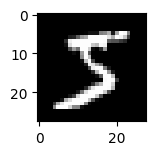

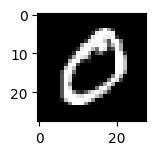

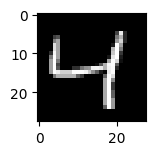

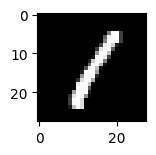

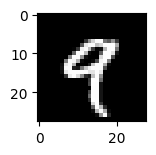

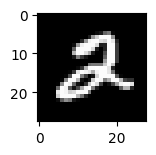

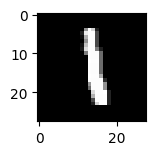

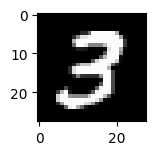

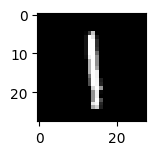

In [ ]:
for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(train_X[i], cmap='gray')
  plt.show()

In [ ]:
print("train_X: ",train_X.shape)
print("train_y: ",train_y.shape)
print("test_X: ",test_X.shape)
print("test_y: ",test_y.shape)

train_X:  (60000, 28, 28)
train_y:  (60000,)
test_X:  (10000, 28, 28)
test_y:  (10000,)


Appllying CNN


In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax') # 10 calsses for digits 0-9
])

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(train_X, train_y, epochs=10, validation_split=0.3)

Epoch 1/10
1313/1313 [==============================] - 13s 6ms/step - loss: 0.1453 - accuracy: 0.9547 - val_loss: 0.0611 - val_accuracy: 0.9817
Epoch 2/10
1313/1313 [==============================] - 7s 6ms/step - loss: 0.0463 - accuracy: 0.9861 - val_loss: 0.0531 - val_accuracy: 0.9826
Epoch 3/10
1313/1313 [==============================] - 7s 5ms/step - loss: 0.0333 - accuracy: 0.9900 - val_loss: 0.0457 - val_accuracy: 0.9863
Epoch 4/10
1313/1313 [==============================] - 7s 6ms/step - loss: 0.0242 - accuracy: 0.9923 - val_loss: 0.0514 - val_accuracy: 0.9854
Epoch 5/10
1313/1313 [==============================] - 7s 5ms/step - loss: 0.0184 - accuracy: 0.9941 - val_loss: 0.0426 - val_accuracy: 0.9882
Epoch 6/10
1313/1313 [==============================] - 8s 6ms/step - loss: 0.0168 - accuracy: 0.9945 - val_loss: 0.0506 - val_accuracy: 0.9871
Epoch 7/10
1313/1313 [==============================] - 6s 5ms/step - loss: 0.0135 - accuracy: 0.9954 - val_loss: 0.0481 - val_accuracy

In [ ]:
loss, accuracy = model.evaluate(test_X, test_y)

313/313 [==============================] - 1s 3ms/step - loss: 0.0458 - accuracy: 0.9895


In [ ]:
print(accuracy)

0.9894999861717224


In [ ]:
pred_y_prob = model.predict(test_X)
pred_y = np.argmax(pred_y_prob, axis=1)

313/313 [==============================] - 1s 2ms/step


In [ ]:
print(pred_y)

[7 2 1 ... 4 5 6]


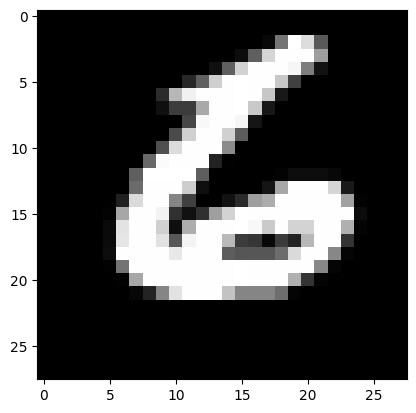

In [ ]:
plt.imshow(test_X[-1], cmap='gray')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(test_y, pred_y, average='weighted')
recall = recall_score(test_y, pred_y, average='weighted')

In [ ]:
print("Precision: ", precision)
print("Recall: ", recall)

Precision:  0.9895694675733313
Recall:  0.9895


In [ ]:
def preprocess_image(img):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Resize the image to 28x28 pixels
    resized = cv2.resize(gray, (28, 28), interpolation=cv2.INTER_AREA)
    # Normalize the image
    normalized = resized / 255.0
    # Reshape the image to add a batch dimension
    reshaped = np.reshape(normalized, (1, 28, 28, 1))
    return reshaped

In [ ]:
from google.colab.patches import cv2_imshow

Getting images live from webcam and predicting the values from live images

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    resized = cv2.resize(gray, (28, 28), interpolation=cv2.INTER_AREA)
    # Normalize the image
    normalized = resized / 255.0

    reshaped = np.reshape(normalized, (1, 28, 28, 1))

    # Make predictions
    predictions = model.predict(reshaped)
    predicted_digit = np.argmax(predictions)

    print(predicted_digit)
    # # Display the resulting frame with prediction
    # cv2.putText(img, f'Prediction: {predicted_digit}', (10, 30),
    #             cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    # # cv2_imshow(img)

    # bbox_array[:,:,3] = (img.max(axis = 2) > 0 ).astype(int) * 255
    # # convert overlay of bbox into bytes
    # bbox_bytes = bbox_to_bytes(bbox_array)
    # # update bbox so next frame gets new overlay
    # bbox = bbox_bytes

    # # Press 'q' to exit the loop
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break

    # get face region coordinates
    # faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    bbox_array = cv2.putText(bbox_array, f'Prediction: {predicted_digit}', (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    # for (x,y,w,h) in faces:
    #   bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 19ms/step
1
1/1 [==============================] - 0s 18ms/step
1
